In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as m
from sklearn.tree import DecisionTreeRegressor

In [2]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [3]:
df = pd.read_csv("../../../data/cleaned/wind_hourly_cleaned.csv")
df = df.sort_values('datetime').reset_index(drop=True)
df['wind_speed'] = df['wind_speed'].astype(float)

In [4]:
LAGS = [1,2,3,23,24,25,48]
df = df.join(make_lags(df[['wind_speed']], ['wind_speed'], LAGS)).dropna()

In [5]:
df.head()

,datetime,wind_speed,wind_speed_L1,wind_speed_L2,wind_speed_L3,wind_speed_L23,wind_speed_L24,wind_speed_L25,wind_speed_L48
48,2024-01-03 00:00:00,0.100000,0.800000,1.000000,0.216667,0.933333,1.050000,0.716667,0.100000
49,2024-01-03 01:00:00,0.616667,0.100000,0.800000,1.000000,0.700000,0.933333,1.050000,0.283333
50,2024-01-03 02:00:00,0.500000,0.616667,0.100000,0.800000,1.450000,0.700000,0.933333,0.200000
51,2024-01-03 03:00:00,0.033333,0.500000,0.616667,0.100000,1.750000,1.450000,0.700000,0.500000
52,2024-01-03 04:00:00,0.116667,0.033333,0.500000,0.616667,0.083333,1.750000,1.450000,0.966667


In [6]:
train_end = len(df) - 720
test_df   = df.iloc[train_end:].copy()


In [7]:
preds = []
for t in range(train_end, len(df)):
    X = df.iloc[t-168:t][[c for c in df.columns if '_L' in c]].values
    y = df.iloc[t-168:t]['wind_speed'].values
    model = DecisionTreeRegressor(max_depth=8, min_samples_leaf=10, random_state=42)
    model.fit(X, y)
    x_next = df.iloc[t][[c for c in df.columns if '_L' in c]].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])

test_df['pred_dt'] = preds
mae  = m.mean_absolute_error(test_df['wind_speed'], test_df['pred_dt'])
rmse = m.mean_squared_error(test_df['wind_speed'], test_df['pred_dt'])
mape = np.mean(np.abs((test_df['wind_speed'] - test_df['pred_dt'])/test_df['wind_speed']))*100

In [8]:
# --- REPORT PRINTING ---
print("\n=======================================================")
print("  DECISION TREE FORECAST PERFORMANCE REPORT")
print("=======================================================")
print(f"Total Test Observations: {len(test_df):,}")
print("-" * 55)
print("Metric                         Value")
print("-" * 55)
print(f"Mean Absolute Error (MAE):     {mae:20.4f}")
print(f"Root Mean Squared Error (RMSE):{rmse:20.4f}")
print(f"Mean Abs. Percentage Error (MAPE): {mape:18.2f} %")
print("=======================================================")


  DECISION TREE FORECAST PERFORMANCE REPORT
Total Test Observations: 720
-------------------------------------------------------
Metric                         Value
-------------------------------------------------------
Mean Absolute Error (MAE):                   0.8246
Root Mean Squared Error (RMSE):              1.3596
Mean Abs. Percentage Error (MAPE):                inf %


# Step-2 retuned Decision-Tree with cyclical hour-of-day

In [9]:
# ensure the column is datetime *type*
df['date'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['date'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [10]:
df = df.dropna()

In [11]:
# 3. train/test split (last 720 rows locked)
train_end = len(df) - 720
test_df = df.iloc[train_end:].copy()

FEATS = [c for c in df.columns if '_L' in c] + ['sin_h', 'cos_h']


In [12]:
preds = []
for t in range(train_end, len(df)):

    # Rolling window
    window = df.iloc[t - 168:t]
    X = window[FEATS].values
    y = window["wind_speed"].values

    # Grid search (NO OOB for DecisionTree!)
    best_mae, best_model = np.inf, None
    for d in [4, 6, 8, 10]:
        for ms in [5, 10, 20]:

            mdl = DecisionTreeRegressor(
                max_depth=d,
                min_samples_leaf=ms,
                random_state=42
            )
            mdl.fit(X, y)

            # use in-sample MAE (since no OOB for DecisionTree)
            mae = np.mean(np.abs(y - mdl.predict(X)))

            if mae < best_mae:
                best_mae = mae
                best_model = mdl

    # predict next step
    x_next = df.iloc[t][FEATS].values.reshape(1, -1)
    preds.append(best_model.predict(x_next)[0])


In [13]:
from sklearn import metrics as m
import numpy as np

test_df['pred_dt2'] = preds

# MAE
mae = m.mean_absolute_error(test_df['wind_speed'], test_df['pred_dt2'])

# RMSE (manual)
mse = m.mean_squared_error(test_df['wind_speed'], test_df['pred_dt2'])
rmse = np.sqrt(mse)

# Safe MAPE
actual = test_df['wind_speed'].values
pred   = test_df['pred_dt2'].values

nonzero_mask = actual != 0
if nonzero_mask.sum() == 0:
    mape = np.inf
else:
    mape = np.mean(np.abs((actual[nonzero_mask] - pred[nonzero_mask]) / actual[nonzero_mask])) * 100

print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape, 2) if np.isfinite(mape) else "inf")


MAE : 0.8824
RMSE: 1.2466
MAPE: 144.27


# Step 3 – Gradient-Boosting Regressor 

In [14]:
from sklearn.ensemble import HistGradientBoostingRegressor as HGBR

In [15]:
preds = []
for t in range(train_end, len(df)):
    w = df.iloc[t-168:t]
    X, y = w[FEATS].values, w['wind_speed'].values
    mdl = HGBR(max_iter=200, early_stopping=True, validation_fraction=0.1,
              random_state=42).fit(X, y)
    preds.append(mdl.predict(df.iloc[t][FEATS].values.reshape(1, -1))[0])


In [16]:
test_df['pred_hgb'] = preds


In [17]:
print('MAE :', m.mean_absolute_error(test_df['wind_speed'], test_df['pred_hgb']))

MAE : 0.8220464081552772


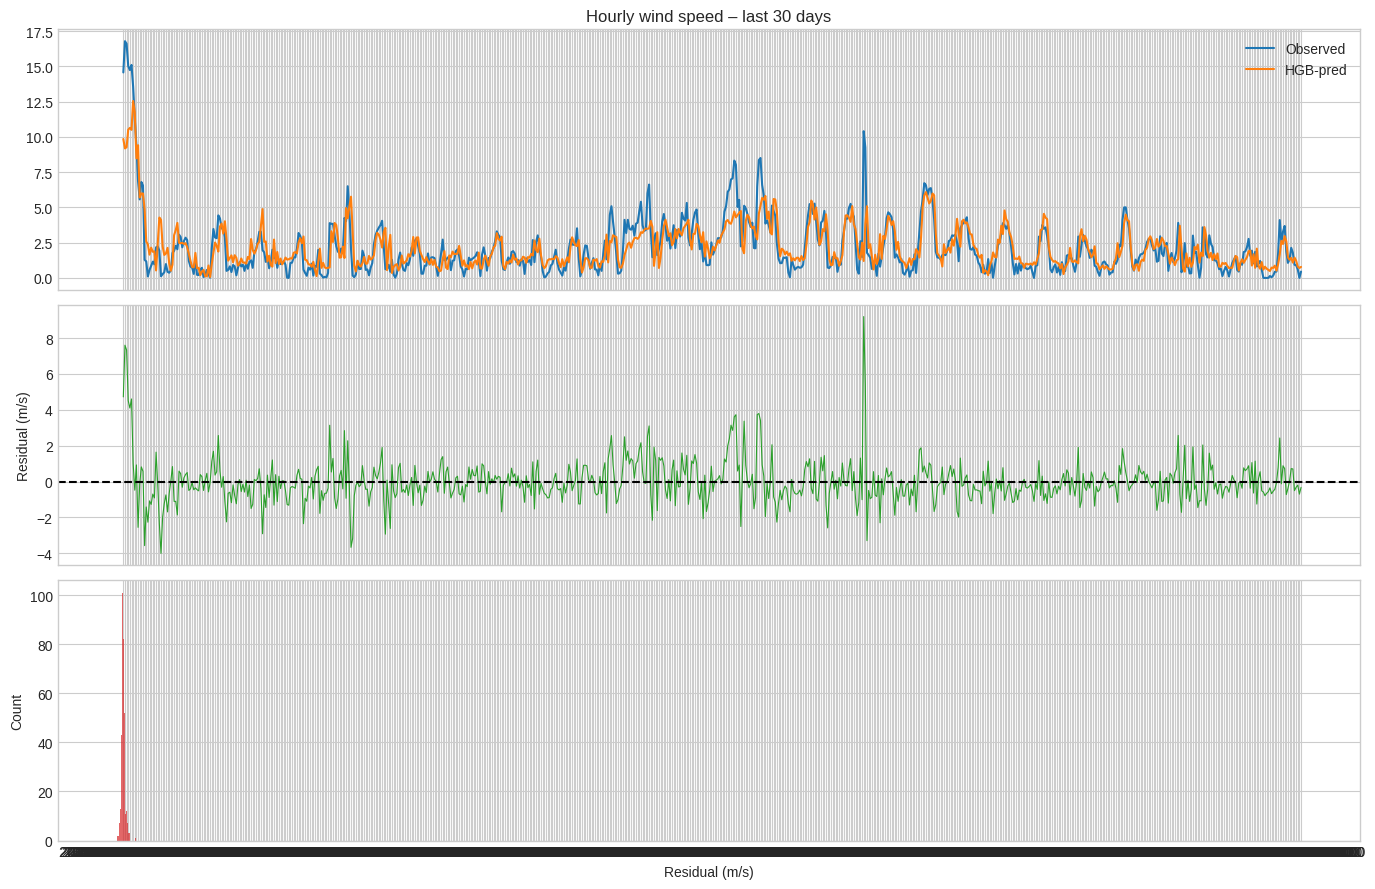

In [18]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(3,1, figsize=(14,9), sharex=True)

# 1. raw series vs forecast
ax[0].plot(test_df['datetime'], test_df['wind_speed'], label='Observed')
ax[0].plot(test_df['datetime'], test_df['pred_hgb'], label='HGB-pred')
ax[0].set_title('Hourly wind speed – last 30 days')
ax[0].legend()

# 2. residual
resid = test_df['wind_speed'] - test_df['pred_hgb']
ax[1].plot(test_df['datetime'], resid, color='C2', lw=0.8)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_ylabel('Residual (m/s)')

# 3. residual histogram
ax[2].hist(resid, bins=50, alpha=0.7, color='C3')
ax[2].set_xlabel('Residual (m/s)')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('hgb_vs_obs.png', dpi=150)
plt.show()

# Random-Forest Regressor (same 9-feature set, 1-hour-ahead)

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [20]:
param = {'max_depth':[None,8,12], 'min_samples_leaf':[1,3,5]}
preds = []

tscv = TimeSeriesSplit(n_splits=5)  # correct CV for rolling forecast

for t in range(train_end, len(df)):
    # rolling window
    w = df.iloc[t-168:t]
    X, y = w[FEATS].values, w['wind_speed'].values
    
    # grid search with time series split
    gs = GridSearchCV(
        RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        param,
        cv=tscv,
        scoring='neg_mean_absolute_error'
    ).fit(X, y)
    
    # predict next step
    x_next = df.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(gs.best_estimator_.predict(x_next)[0])


In [21]:

test_df['pred_rf'] = preds
print('MAE :', m.mean_absolute_error(test_df['wind_speed'], test_df['pred_rf']))

MAE : 0.7245530134596739


In [22]:
test_df['pred_rf'] = preds
print('MAE :', m.mean_absolute_error(test_df['wind_speed'], test_df['pred_rf']))
print('RMSE:', np.sqrt(m.mean_squared_error(test_df['wind_speed'], test_df['pred_rf'])))
print('MAPE:', np.mean(np.abs((test_df['wind_speed'] - test_df['pred_rf']) / test_df['wind_speed'])) * 100)

MAE : 0.7245530134596739
RMSE: 1.0372028301741198
MAPE: inf


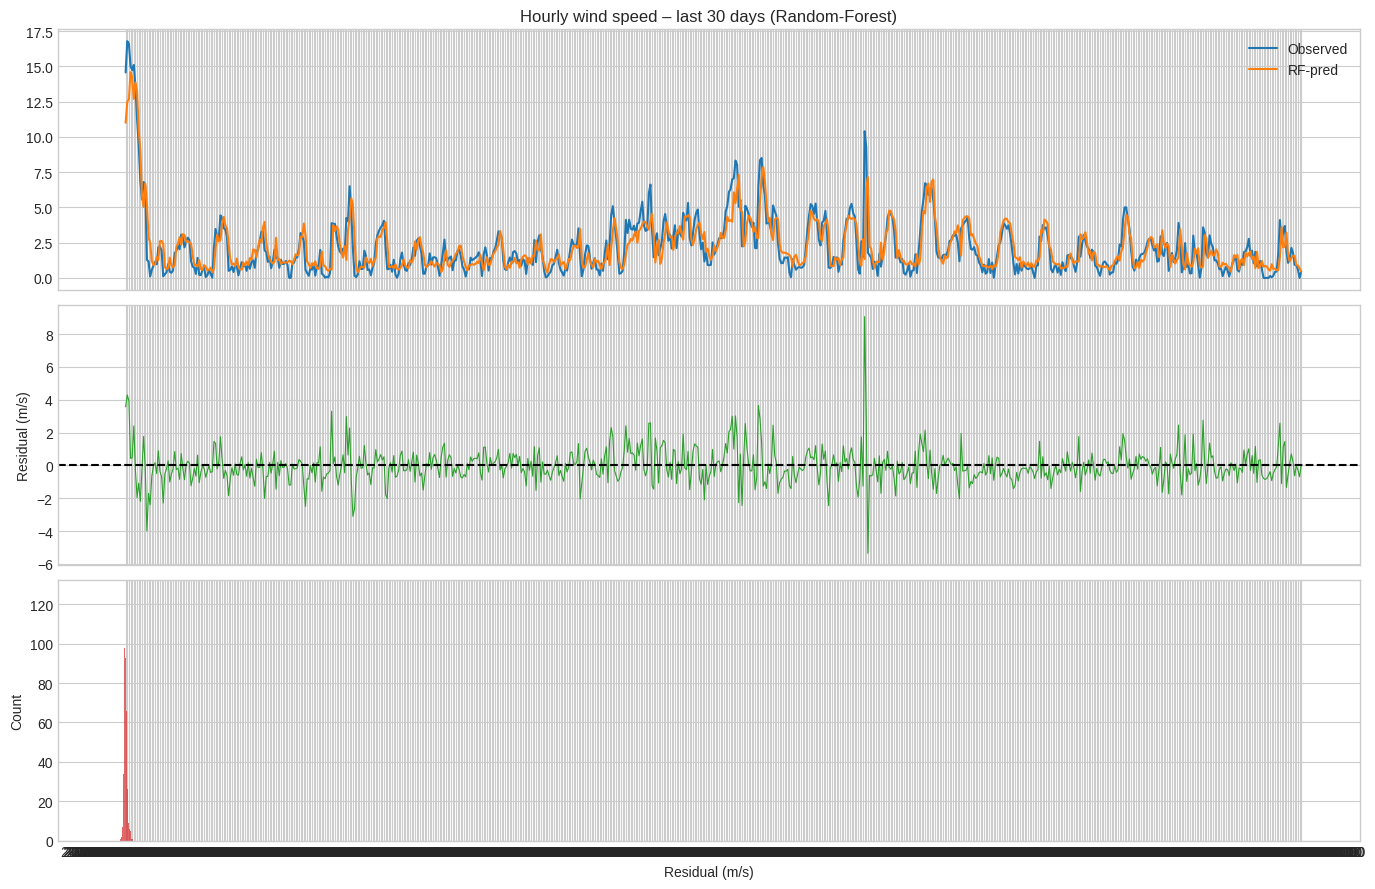

In [23]:
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(3,1, figsize=(14,9), sharex=True)

# 1. raw series vs RF forecast
ax[0].plot(test_df['datetime'], test_df['wind_speed'], label='Observed')
ax[0].plot(test_df['datetime'], test_df['pred_rf'], label='RF-pred')
ax[0].set_title('Hourly wind speed – last 30 days (Random-Forest)')
ax[0].legend()

# 2. residuals
resid = test_df['wind_speed'] - test_df['pred_rf']
ax[1].plot(test_df['datetime'], resid, color='C2', lw=0.8)
ax[1].axhline(0, color='k', ls='--')
ax[1].set_ylabel('Residual (m/s)')

# 3. residual histogram
ax[2].hist(resid, bins=50, alpha=0.7, color='C3')
ax[2].set_xlabel('Residual (m/s)')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('rf_vs_obs.png', dpi=150)
plt.show()

wind_speed_L1     0.624701
cos_h             0.092388
wind_speed_L48    0.063802
wind_speed_L23    0.062189
wind_speed_L25    0.039250
wind_speed_L24    0.037805
wind_speed_L2     0.031078
sin_h             0.030822
wind_speed_L3     0.017965
dtype: float64


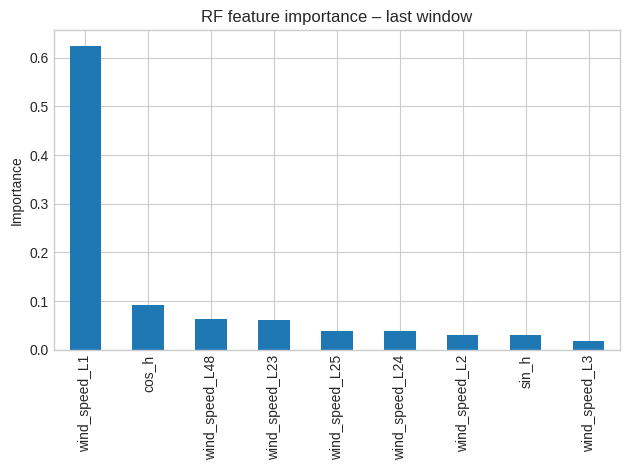

In [24]:
# pick the last trained RF
last_rf = gs.best_estimator_  # from the final t in the loop
imp = pd.Series(last_rf.feature_importances_, index=FEATS).sort_values(ascending=False)
print(imp)

# quick bar
imp.plot.bar()
plt.title('RF feature importance – last window')
plt.ylabel('Importance')
plt.tight_layout(); plt.savefig('rf_importance.png', dpi=150); plt.show()